In [21]:
import sys
import os
from datetime import datetime
import json
import shutil
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm_notebook, tqdm
from matplotlib import pyplot as plt

sys.path.append('../src/')
import agent as TAgent
import env as BTCEnv
import DQNtrainer as DQNTrainer
import DRLtrainer as DRLTrainer
from collections import deque

import ast
from importlib import reload 

In [22]:
TAgent=reload(TAgent)
BTCEnv=reload(BTCEnv)
DQNTrainer=reload(DQNTrainer)
DRLTrainer=reload(DRLTrainer)

In [23]:
obs_space = (8,20)
act_space = 1

money = 20000
fee = 0.001
episodes = 1
runs_p_eps = 1
TAgent=reload(TAgent)
BTCEnv=reload(BTCEnv)
env = BTCEnv.BTCMarket_Env(observation_space = obs_space,
            action_space = act_space,
            start_money = money,
            source_file = "BTC_histData_dt1800.0s_20220825_0629",
            trading_fee= fee,
            reward_function ='reward_differential_sharpe_ratio')

agent = TAgent.Trader_Agent(observation_space = obs_space,
            action_space = act_space,
            epsilon = 0.0001)

drltrainer = DRLTrainer.DRLTrainer(env, agent,
                observation_space = obs_space,
                action_space = act_space,
                batch_size=16, 
                learning_rate=1e-8,
                lstm_path="./best_models/11_mar_2023/best_model_sequential_20back_10ahead.h5",)

# drltrainer.rollout(n_episodes=episodes, run_per_episode=runs_p_eps)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 8)]      0           []                               
                                                                                                  
 lstm_inputs (Lambda)           (None, 20, 4)        0           ['input_1[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 10)           1953940     ['lstm_inputs[0][0]']            
                                                                                                  
 flatten_1 (Flatten)            (None, 10)           0           ['sequential[0][0]']             
                                                                                              

In [24]:
drltrainer.rollout(n_episodes=1, run_per_episode=1)

Episode: 1/1
Episode: 1/1 || Run 1/1


  2%|▏         | 16/671 [00:02<01:21,  8.06it/s]

1/1 [==============================] - 3s 3s/step - loss: -2.8045e-05


  5%|▍         | 33/671 [00:07<01:33,  6.80it/s]

1/1 [==============================] - 0s 6ms/step - loss: -1.1611e-04


  7%|▋         | 50/671 [00:10<01:28,  7.00it/s]

1/1 [==============================] - 0s 6ms/step - loss: -1.7574e-04


 10%|▉         | 67/671 [00:12<01:25,  7.04it/s]

1/1 [==============================] - 0s 6ms/step - loss: -1.5048e-04


 13%|█▎        | 84/671 [00:15<01:23,  7.06it/s]

1/1 [==============================] - 0s 6ms/step - loss: -1.1130e-04


 15%|█▌        | 101/671 [00:17<01:39,  5.75it/s]

Data saved
episode 1, run (1/1) sample (100/671).Profit 899.6500000000015 || money available: [12567.19],  wallet value: [20899.65]
1/1 [==============================] - 0s 10ms/step - loss: -8.7269e-05


 18%|█▊        | 118/671 [00:20<01:19,  6.94it/s]

1/1 [==============================] - 0s 6ms/step - loss: -8.0368e-05


 20%|██        | 135/671 [00:22<01:16,  7.01it/s]

1/1 [==============================] - 0s 7ms/step - loss: -8.0045e-05


 23%|██▎       | 151/671 [00:25<01:13,  7.07it/s]

1/1 [==============================] - 0s 6ms/step - loss: -6.6701e-05


 25%|██▌       | 169/671 [00:27<01:12,  6.89it/s]

1/1 [==============================] - 0s 6ms/step - loss: -7.3368e-05


 28%|██▊       | 186/671 [00:30<02:03,  3.91it/s]

1/1 [==============================] - 0s 6ms/step - loss: -7.6868e-05


 30%|███       | 202/671 [00:33<01:04,  7.25it/s]

Data saved
episode 1, run (1/1) sample (200/671).Profit 1056.2999999999993 || money available: [12609.03],  wallet value: [21056.3]


 30%|███       | 203/671 [00:33<01:05,  7.20it/s]

1/1 [==============================] - 0s 6ms/step - loss: -8.2223e-05


 33%|███▎      | 220/671 [00:36<01:04,  6.97it/s]

1/1 [==============================] - 0s 6ms/step - loss: -4.6471e-05


 35%|███▌      | 237/671 [00:38<01:01,  7.03it/s]

1/1 [==============================] - 0s 6ms/step - loss: -2.0214e-05


 38%|███▊      | 254/671 [00:41<00:59,  7.04it/s]

1/1 [==============================] - 0s 6ms/step - loss: 2.7273e-05


 40%|████      | 271/671 [00:43<00:57,  6.97it/s]

1/1 [==============================] - 0s 6ms/step - loss: -3.7222e-06


 43%|████▎     | 288/671 [00:46<00:54,  7.08it/s]

1/1 [==============================] - 0s 5ms/step - loss: -1.7790e-05


 45%|████▌     | 302/671 [00:48<01:00,  6.08it/s]

Data saved
episode 1, run (1/1) sample (300/671).Profit 667.2999999999993 || money available: [14467.11],  wallet value: [20667.3]


 45%|████▌     | 305/671 [00:48<00:54,  6.72it/s]

1/1 [==============================] - 0s 6ms/step - loss: -3.7125e-05


 48%|████▊     | 322/671 [00:51<00:49,  7.04it/s]

1/1 [==============================] - 0s 6ms/step - loss: -2.1613e-05


 51%|█████     | 339/671 [00:53<00:46,  7.10it/s]

1/1 [==============================] - 0s 6ms/step - loss: -3.2113e-05


 53%|█████▎    | 356/671 [00:56<00:44,  7.07it/s]

1/1 [==============================] - 0s 6ms/step - loss: -5.2869e-05


 56%|█████▌    | 373/671 [00:58<00:42,  7.05it/s]

1/1 [==============================] - 0s 6ms/step - loss: -6.2803e-05


 58%|█████▊    | 390/671 [01:01<00:39,  7.12it/s]

1/1 [==============================] - 0s 5ms/step - loss: -5.2657e-05


 60%|█████▉    | 402/671 [01:03<00:45,  5.95it/s]

Data saved
episode 1, run (1/1) sample (400/671).Profit 895.9300000000003 || money available: [14627.15],  wallet value: [20895.93]


 61%|██████    | 407/671 [01:03<00:38,  6.85it/s]

1/1 [==============================] - 0s 6ms/step - loss: -6.3879e-05


 63%|██████▎   | 424/671 [01:07<00:36,  6.72it/s]

1/1 [==============================] - 0s 6ms/step - loss: -1.0886e-04


 66%|██████▌   | 441/671 [01:09<00:33,  6.96it/s]

1/1 [==============================] - 0s 6ms/step - loss: -1.1176e-04


 68%|██████▊   | 458/671 [01:12<00:30,  7.02it/s]

1/1 [==============================] - 0s 6ms/step - loss: -1.1912e-04


 71%|███████   | 475/671 [01:14<00:27,  7.01it/s]

1/1 [==============================] - 0s 6ms/step - loss: -8.8705e-05


 73%|███████▎  | 492/671 [01:17<00:25,  6.99it/s]

1/1 [==============================] - 0s 6ms/step - loss: -6.0495e-05


 75%|███████▍  | 502/671 [01:18<00:28,  5.93it/s]

Data saved
episode 1, run (1/1) sample (500/671).Profit 1194.369999999999 || money available: [10597.19],  wallet value: [21194.37]


 76%|███████▌  | 509/671 [01:19<00:23,  6.94it/s]

1/1 [==============================] - 0s 6ms/step - loss: -4.4595e-05


 78%|███████▊  | 526/671 [01:22<00:20,  6.98it/s]

1/1 [==============================] - 0s 6ms/step - loss: 6.2692e-05


 81%|████████  | 543/671 [01:25<00:20,  6.18it/s]

1/1 [==============================] - 0s 6ms/step - loss: 1.5525e-04


 83%|████████▎ | 560/671 [01:28<00:16,  6.73it/s]

1/1 [==============================] - 0s 6ms/step - loss: 1.2863e-04


 86%|████████▌ | 577/671 [01:30<00:13,  7.03it/s]

1/1 [==============================] - 0s 6ms/step - loss: 7.2497e-05


 89%|████████▊ | 594/671 [01:33<00:11,  6.73it/s]

1/1 [==============================] - 0s 6ms/step - loss: 5.7910e-05


 90%|████████▉ | 602/671 [01:34<00:12,  5.73it/s]

Data saved
episode 1, run (1/1) sample (600/671).Profit 410.4300000000003 || money available: [14287.3],  wallet value: [20410.43]


 91%|█████████ | 611/671 [01:35<00:08,  6.96it/s]

1/1 [==============================] - 0s 6ms/step - loss: 6.4902e-05


 94%|█████████▎| 628/671 [01:38<00:06,  7.06it/s]

1/1 [==============================] - 0s 6ms/step - loss: 6.8137e-05


 96%|█████████▌| 645/671 [01:40<00:03,  7.01it/s]

1/1 [==============================] - 0s 6ms/step - loss: 2.3042e-05


 99%|█████████▊| 662/671 [01:43<00:01,  6.72it/s]

1/1 [==============================] - 0s 6ms/step - loss: 7.3781e-06


100%|█████████▉| 668/671 [01:45<00:00,  6.35it/s]


Data saved
episode 1, finished run (1/1). Run Profit 415.83000000000175 || money available: [10207.92],  wallet value: [20415.83]
episode 1/1. Profit 415.83000000000175 || money available: [10207.92],  wallet value: [20415.83]
Data saved


../src/DRLtrainer.py:413: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  train_log_dataframe = pd.concat([train_log_dataframe, tmp])


## Visualizations

In [25]:
train_path = "../data/20230418_162100/DRL"

In [26]:
dftr = pd.read_csv(f'{train_path}/Trainer_Data_1.csv',sep=";")
print(dftr.shape)
dftr.head()

(669, 9)


,episode,run,action,state,reward,done,epsilon,profit,time_elapsed
0,1.0,1.0,[0.40518007],[[[0.5 0.99983487 0.5 0.5 ...,[0.],0.0,0.0001,-8.00,0.305147
1,1.0,1.0,[0.39025277],[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,[1.4834396e-05],0.0,0.0001,21.77,0.427744
2,1.0,1.0,[0.37110192],[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,[2.39132628e-05],0.0,0.0001,40.33,0.551003
3,1.0,1.0,[0.4131637],[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,[2.55258405e-05],0.0,0.0001,44.05,0.672450
4,1.0,1.0,[0.3721071],[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,[6.16453355e-05],0.0,0.0001,117.92,0.796497


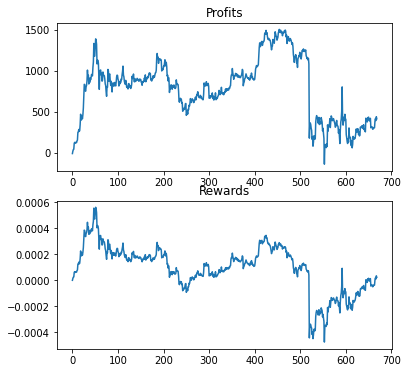

In [27]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(dftr.profit)
ax[0].set_title("Profits")
y = [ast.literal_eval(x)[0] for x  in dftr.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()

In [28]:
with open(f"{train_path}/train_data.json") as fd:
    history = json.load(fd)

In [12]:
print(history.keys())

dict_keys(['Epi_1'])


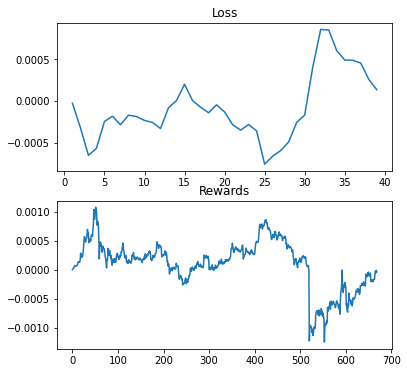

In [13]:
loss_values = history['Epi_1']['loss']
epochs = range(1, len(loss_values)+1)


fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[0].plot(epochs, loss_values, label='Training Loss')
ax[0].set_title("Loss")
y = [ast.literal_eval(x)[0] for x  in dftr.reward]
ax[1].plot(y)
ax[1].set_title("Rewards")
plt.show()


In [14]:
dfep = pd.read_csv(f'{train_path}/episodes/Epi_1_run_1_BTC.csv', sep=";")
print(dfep.shape)
dfep.head()

(670, 23)


,btc_price,btc_units,money,buy_long_count,state,fee_paid,short_wallet,wallet_value,product_price,short_units,...,action,btc_eur,long_position,funding_rate,done,buy_short_count,reward,sell_short_count,short_position,short_eur
0,7815.30,0,[20000],0,[[[0.5 0.99983487 0.5 0.5 ...,0,"[0, 0]",20000.00,7815.30,0,...,[0],0,0.0,0,False,0,[0.],0,-0.0,-0.0
1,7812.15,[1.02363644],[11995.2],1,[[[0.5 0.99983487 0.5 0.5 ...,[7.9968014],"[0, 0]",19992.00,7812.15,0,...,[0.4],[7996.8013986],0.4,0,False,0,[0.],0,-0.0,-0.0
2,7841.23,[1.02363644],[11995.2],1,[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,0,"[0, 0]",20021.77,7841.23,0,...,[0.4],[7996.8013986],0.4,0,False,0,[1.4834396e-05],0,-0.0,-0.0
3,7859.36,[1.02363644],[11995.2],1,[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,0,"[0, 0]",20040.33,7859.36,0,...,[0.4],[7996.8013986],0.4,0,False,0,[2.39132628e-05],0,-0.0,-0.0
4,7863.00,[1.02363644],[11995.2],1,[[[5.00000000e-01 9.99834868e-01 5.00000000e-0...,0,"[0, 0]",20044.05,7863.00,0,...,[0.4],[7996.8013986],0.4,0,False,0,[2.55258405e-05],0,-0.0,-0.0


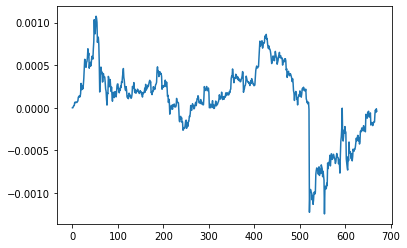

In [15]:
y = [ast.literal_eval(x)[0] for x  in dfep.reward]
plt.plot(y)

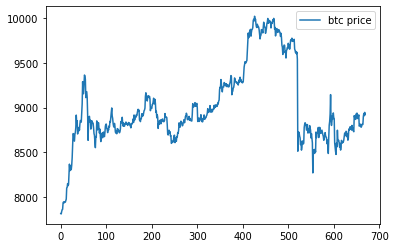

In [16]:
wallet = dfep['wallet_value'].values
btc = dfep['btc_price'].values

# plt.plot(wallet, label='wallet value')
plt.plot(btc, label='btc price')
plt.legend()

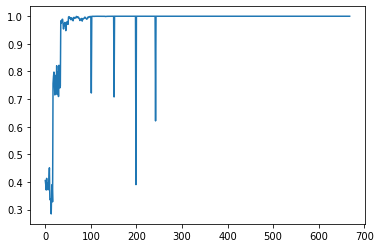

In [17]:
tmp = [ast.literal_eval(n) for n in dftr["action"]]
plt.plot(tmp)

Text(0.5, 1.0, 'Actions')

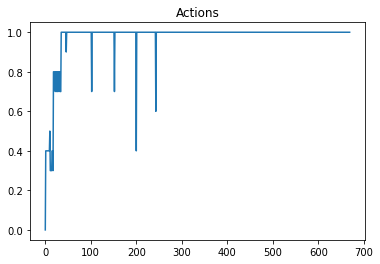

In [18]:
actions = dfep['action'].values
y = [ast.literal_eval(x)[0] for x  in actions]

plt.plot(y)
plt.title('Actions')

In [19]:
plt.plot(drltrainer.custom_loss.environment_data["price_change"])

TypeError: 'NoneType' object is not subscriptable

In [27]:
tmp = [x[0,0] for x in drltrainer.custom_loss.save_drs] 
plt.plot(tmp)

TypeError: <tf.Tensor 'DRLLossFunctions/sub_1:0' shape=(None, 1) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'DRLLossFunctions/sub_1:0' shape=(None, 1) dtype=float32> was defined here:
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 374, in dispatch_queue
      yield self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-7-a81fe3169eff>", line 1, in <module>
      drltrainer.rollout(n_episodes=1, run_per_episode=1)
    File "../src/DRLtrainer.py", line 283, in rollout
      res = self.batch_train()
    File "../src/DRLtrainer.py", line 386, in batch_train
      result=self.agent.model.fit(x_train, y_target,
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/def_function.py", line 915, in __call__
      result = self._call(*args, **kwds)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/def_function.py", line 963, in _call
      self._initialize(args, kwds, add_initializers_to=initializers)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/def_function.py", line 785, in _initialize
      self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/function.py", line 2523, in _get_concrete_function_internal_garbage_collected
      graph_function, _ = self._maybe_define_function(args, kwargs)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/function.py", line 2760, in _maybe_define_function
      graph_function = self._create_graph_function(args, kwargs)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/function.py", line 2670, in _create_graph_function
      func_graph_module.func_graph_from_py_func(
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/func_graph.py", line 1247, in func_graph_from_py_func
      func_outputs = python_func(*func_args, **func_kwargs)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/def_function.py", line 677, in wrapped_fn
      out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/func_graph.py", line 1222, in autograph_handler
      return autograph.converted_call(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 1315, in run
      return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 2891, in call_for_each_replica
      return self._call_for_each_replica(fn, args, kwargs)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 3692, in _call_for_each_replica
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "../src/DRLtrainer.py", line 119, in call
      loss = self.loss_fn(y_true, y_pred)
    File "../src/DRLtrainer.py", line 85, in reward_differential_sharpe_ratio
      dsr = expected_return - (gamma/ 2) * variance_returns_squared
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/math_ops.py", line 1407, in binary_op_wrapper
      return func(x, y, name=name)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py", line 1176, in op_dispatch_handler
      return dispatch_target(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/math_ops.py", line 548, in subtract
      return gen_math_ops.sub(x, y, name)
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 11175, in sub
      _, _, _op, _outputs = _op_def_library._apply_op_helper(
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/op_def_library.py", line 797, in _apply_op_helper
      op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/func_graph.py", line 735, in _create_op_internal
      return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/ops.py", line 3800, in _create_op_internal
      ret = Operation(

The tensor <tf.Tensor 'DRLLossFunctions/sub_1:0' shape=(None, 1) dtype=float32> cannot be accessed from here, because it was defined in FuncGraph(name=train_function, id=140323563323648), which is out of scope.

In [40]:
drltrainer.custom_loss.save_drs

[<tf.Tensor 'DRLLossFunctions/sub_1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'DRLLossFunctions/sub_1:0' shape=(None, 1) dtype=float32>]

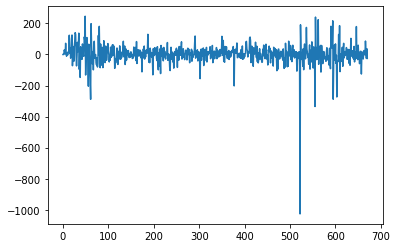

In [23]:
test =tf.gather(drltrainer.custom_loss.environment_data["price_change"], 
                    [i for i in range(len(drltrainer.custom_loss.environment_data["price_change"]))])

plt.plot(test)

In [42]:
idx = tf.roll(tf.cast( [i for i in range(len(drltrainer.custom_loss.environment_data["product_price"]))], 
                      tf.int32), shift=-1, axis=0)
old_price = tf.gather(drltrainer.custom_loss.environment_data["product_price"], 
                     [i for i in range(len(drltrainer.custom_loss.environment_data["product_price"]))])

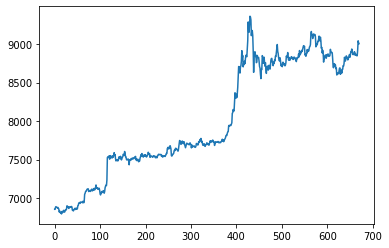

In [43]:
plt.plot(old_price)

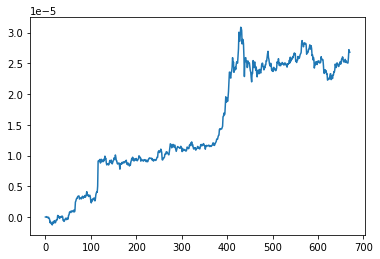

In [24]:

plt.plot(drltrainer.custom_loss.environment_data["expected_return"])

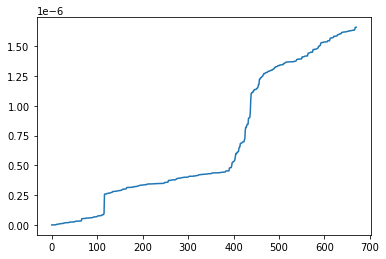

In [25]:
plt.plot(drltrainer.custom_loss.environment_data["var_returns_squared"])

## Train step by step

In [4]:
env.reset()
data_samples = env.episode_length
memory = deque()

state, _, _ = env.step(np.array([0]))
for t in tqdm(range(55)):
    # Compute Action
    tmp_wallet_value = env.wallet_value
    action = agent.compute_action(state)
    # Compute new step
    next_state, reward, done = env.step(action=action)
    # save Experience to Memory
    memory.append((state, action, reward, next_state, done))
    state = next_state

100%|██████████| 55/55 [00:08<00:00,  6.65it/s]


In [10]:
batch_size = 50


batch = []
# for i in range(1):
for i in range(max([len(memory) - batch_size,0]), len(memory)):
    batch.append(memory[i])

# Change here to fit new RL-Algo
# for index in range(0,len(batch)-1):

x_train = np.zeros((batch_size, 20,8))
y_train = np.zeros((batch_size, 4))
print(len(batch))


state, _, reward, next_state , done = batch[0]
action = agent.model.predict(state,verbose = 0)
for index in range(1,len(batch)):
    # Compute Reward Decay for DQN
    action_next = agent.model.predict(next_state,verbose = 0)
#     if not done:
#         reward += dqntrainer.gamma * np.max(action_next)
        
    if np.any(np.isnan(reward)) or np.any(np.isnan(action)):
        print(reward)
        print(action)
    target = np.nan_to_num(action,nan=0.0)      
    id_act = np.argmax(target)
    target[0,id_act] = reward
    
    target = np.nan_to_num(target,nan=0.0)
    state = np.nan_to_num(state,nan=0.0)
    x_train[index]= state[0]
    y_train[index]= target[0]
    
    
    # update state, action, reward for training
    state, _, reward, next_state , done = batch[index]
    action = action_next


result=agent.model.fit(x_train, y_train, epochs=5, verbose=1)
# agent.update_epsilon()


50
Epoch 1/5
2/2 [==============================] - 4s 7ms/step - loss: -0.0086
Epoch 2/5
2/2 [==============================] - 0s 5ms/step - loss: -0.0112
Epoch 3/5
2/2 [==============================] - 0s 5ms/step - loss: -0.0121
Epoch 4/5
2/2 [==============================] - 0s 4ms/step - loss: -0.0123
Epoch 5/5
2/2 [==============================] - 0s 4ms/step - loss: -0.0123
